# Linear Regression  on a Combined Cycle Power Plant (CCPP) data
## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [36]:
# to get in-line plots
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats

## Import Data
Load the data from a .csv file

**TO DO:** insert your ID number (matricola)


In [37]:
# Load the data

IDnumber = 1204879
np.random.seed(IDnumber)

filename = "ccpp_Data_clean2018.csv"

Data = np.genfromtxt(filename, delimiter=';',skip_header=1)


# A quick overview of data

To inspect the data you can use the method describe()

In [39]:
dataDescription = stats.describe(Data)
print(dataDescription)

Data.shape

#for more interesting visualization: use Panda!

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))


(5281, 5)

# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$ for test data. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the training loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat h = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: When different model classes are present (e.g. of different complexity such as linear regression which used a different number $d_j$ of features $x_1$,...$x_{d_j}$ in the model). In general, with more features one can better fit the training set, so one has to choose which one is the "best" complexity. Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training, validation and test sets (suggestion: use $m_t=m_{val} = \lfloor\frac{m}{3}\rfloor$, $m_{test} = m-m_t-m_{val}$)

In [40]:
#get number of total samples
num_total_samples = Data.shape[0]

print("Total number of samples: "+str(num_total_samples))

#size of each chunk of data for training, validation, testing
size_chunk = int(num_total_samples/3.)

print("Size of each chunk of data: "+str(size_chunk))

#shuffle the data
np.random.shuffle(Data)

#training data

X_training = Data[0:size_chunk,0:4]
Y_training = Data[0:size_chunk,4]
print("Training data input size: "+str(X_training.shape))
print("Training data output size: "+str(Y_training.shape))

#validation data, to be used to choose among different models
X_validation = Data[size_chunk:(2*size_chunk),0:4]
Y_validation = Data[size_chunk:(2*size_chunk),4]

print("Validation data input size: "+str(X_validation.shape))
print("Validation data ouput size: "+str(Y_validation.shape))

#test data, to be used to estimate the true loss of the final model(s)
X_test = Data[2*size_chunk:num_total_samples,0:4]
Y_test = Data[2*size_chunk:num_total_samples,4]
print("Test data input size: "+str(X_test.shape))
print("Test data output size: "+str(Y_test.shape))

Total number of samples: 5281
Size of each chunk of data: 1760
Training data input size: (1760, 4)
Training data output size: (1760,)
Validation data input size: (1760, 4)
Validation data ouput size: (1760,)
Test data input size: (1761, 4)
Test data output size: (1761,)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical stability (conditioning) of the (inverse) problems of estimating the ERM model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [41]:
#scale the data

# standardize the input matrix
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)
print("Mean of the training input data:"+str(X_training.mean(axis=0)))
print("Std of the training input data:"+str(X_training.std(axis=0)))
X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print("Mean of the validation input data:"+str(X_validation.mean(axis=0)))
print("Std of the validation input data:"+str(X_validation.std(axis=0)))
X_test = scaler.transform(X_test) # use the same transformation on test data
print("Mean of the test input data:"+str(X_test.mean(axis=0)))
print("Std of the test input data:"+str(X_test.std(axis=0)))


Mean of the training input data:[3.14593679e-15 5.44113365e-15 4.07722751e-13 5.77375900e-15]
Std of the training input data:[1. 1. 1. 1.]
Mean of the validation input data:[ 0.00196769 -0.03350557  0.02720235 -0.04177309]
Std of the validation input data:[0.97519343 0.99538343 0.98036001 0.98795878]
Mean of the test input data:[-0.02345741 -0.04803008  0.0227439   0.02161704]
Std of the test input data:[0.98005424 0.9985994  0.97703925 0.96451154]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
where $z_i = (x_i,y_i)$.
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t}(y - Xw)^T(y-Xw) =  \frac{1}{m_t} \|y - X w\|^2
$$
where $y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X$ is not invertible, the solution can be computed using the Moore-Penrose pseudonverse $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$
The Moore-Penrose pseudoinverse $A^\dagger$ of a matrix $A \in \mathbb{R}^{m\times n}$ can be expressed in terms of the Singular Value Decomposition (SVD) as follows:
Let $A\in \mathbb{R}^{m\times n}$ be of rank $r\leq {\rm min}(n,m)$ and let  
$$
 A = USV^\top
 $$
 be the singular value decomposition of  $A$ where  
 $$
 S = {\rm diag}\{s_1,s_2,..,s_r\}
 $$
 Then 
 $$
 A^\dagger =V S^{-1} U^\top 
 $$
 
 In practice some of the singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to 
 first approximate the matrix $A$ truncating the SVD and then using the pseudoinverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$
 
 The linear regression coefficients can be computed directly using the numyp.linalg.lstsq function
  
 **TO DO**: compute the linear regression coefficients using the numpy.linalg.lstsq function

In [42]:
#compute linear regression coefficients for training data

#add a 1 at the beginning of each sample for training, validation, and testing
m_training = len(X_training)
X_training = np.hstack((np.ones((m_training,1)),X_training))

m_validation = len(X_validation)
X_validation = np.hstack((np.ones((m_validation,1)),X_validation))

m_test = len(X_test)
X_test = np.hstack((np.ones((m_test,1)),X_test))

# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np, RSStr_np, rank_X_tr, sv_X_tr = np.linalg.lstsq(X_training,Y_training,1e-12)

print("LR coefficients with numpy lstsq: "+ str(w_np))

# compute Residual sums of squares by hand
print("RSS with numpy lstsq: "+str(RSStr_np))
print("Empirical risk with numpy lstsq:"+str(RSStr_np/m_training))

LR coefficients with numpy lstsq: [ 4.54087017e+02 -1.52688827e+01 -2.85893486e+00  1.99429840e-01
 -2.40192710e+00]
RSS with numpy lstsq: [37493.86700799]
Empirical risk with numpy lstsq:[21.30333353]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Squares (RSS) defined above, the Emprical Loss and the quantity $1-R^2$ where
$$
R^2 = \frac{\sum_{z_i \in S_t} (\hat y_i - \bar y)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

**TO DO**: Compute these quantities on  training, validation and test sets.


In [43]:
#compute predictions on training set, validation set, and test set
#mean =
#y_estimated_training
#y_estimated_validation
#y_estimated_test
prediction_training=np.zeros(m_training)
prediction_validation=np.zeros(m_validation)
prediction_test=np.zeros(m_test)

for i in range(m_training):
    prediction_training[i] = np.dot(w_np,X_training[i]) 

for i in range(m_validation):
    prediction_validation[i] = np.dot(w_np,X_validation[i])

for i in range(m_test):
    prediction_test[i] = np.dot(w_np,X_test[i])

#what about the RSS and loss for points in the validation data?
RSS_validation = 0.
RSS_test = 0.

for i in range(m_validation):
    RSS_validation += (Y_validation[i]-prediction_validation[i])**2
    
for i in range(m_test):
    RSS_test += (Y_test[i]-prediction_test[i])**2
    
print("RSS on validation data: "+str(RSS_validation))
print("Loss estimated from validation data:"+str(RSS_validation/m_validation))

print("RSS on test data: "+str(RSS_test))
print("Loss estimated from test data:"+str(RSS_test/m_test))

mean_training=0.
mean_test=0.
mean_validation=0.

for i in range(m_training):
     mean_training += Y_training[i]

mean_training/=m_training

for i in range(m_test):
     mean_test += Y_test[i]

mean_test/=m_test

for i in range(m_validation):
     mean_validation += Y_validation[i]

mean_validation/=m_validation

#another measure of how good our linear fit is given by the following (that is 1 - R^2)
#compute 1 -R^2 for training, validation, and test set
num=0.
den=0.

for i in range(m_training):
    num += (prediction_training[i]-mean_training)**2
    den += (Y_training[i]-mean_training)**2

Rmeasure_training = 1-(num/den)
    
num=0.
den=0.

for i in range(m_validation):
    num += (prediction_validation[i]-mean_validation)**2
    den += (Y_validation[i]-mean_validation)**2

Rmeasure_validation = 1-(num/den) 

num=0.
den=0.

for i in range(m_test):
    num += (prediction_test[i]-mean_test)**2
    den += (Y_test[i]-mean_test)**2

Rmeasure_test = 1-(num/den)

print("Measure on Training Data (1-R^2):"+str(Rmeasure_training))
print("Measure on Validation Data(1-R^2):"+str(Rmeasure_validation))
print("Measure on Test Data(1-R^2):"+str(Rmeasure_test))

RSS on validation data: 37333.40064803696
Loss estimated from validation data:21.21215945911191
RSS on test data: 35692.69617863733
Loss estimated from test data:20.268424860100698
Measure on Training Data (1-R^2):0.07084582864869882
Measure on Validation Data(1-R^2):0.05014110043957731
Measure on Test Data(1-R^2):0.0752804751875703


## ... and plot:


### (1) output predictions on training  data

Note that in the following plot and in the analogous plots below the data is permuted so that the predictions are increasing with the index of the instance in the plot. **This is just to make the plot look nice!**

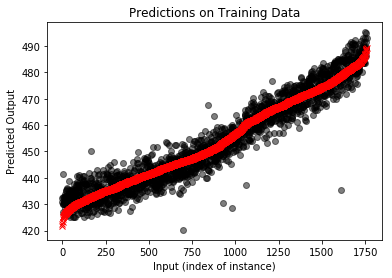

In [44]:
# Plot predictions on Training data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

The linear prediction made on the training set is plotted and compared to "new" samples taken by the validation set.
The data set was divided at the beginning in two parts:
1. Training data
    on which I made the prediction
2. Test data
    on which I evaluate the precision of the linear prediction

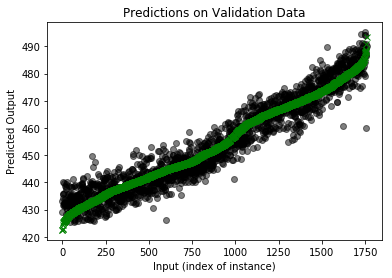

In [45]:
# Plot predictions on validation data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

## Hypothesis testing:

Test significance of each LS coefficients: find rejection regions for the null hypothesis

$$
H_0 : w_j =0
$$

The rejection region (with type-1 probability of error $\alpha$) has the form

$$
{\cal R}_j:=\left\{|\hat w_j|> \Delta\right\} \quad \quad \Delta: = \hat\sigma\ z_{jj}\  t_{1-\frac{\alpha}{2}}(m_t-d-1)
$$
where
$$
\hat\sigma^2 : = \frac{1}{m_t-d-1} RSS(\hat w)
$$
is the estimator of the noise variance, $z_{jj}$ is the square root of the $j-th$ diagonal element of $\left(X^\top X\right)^{-1}$ (here $X$ contains only the training data) and $t_{1-\frac{\alpha}{2}}(m_t-d-1)$ is the $1-\frac{\alpha}{2}$-percentile of the $T$ distribution with $m_t-d-1$ degrees of freedom ($d=4$ in our case), i.e. 
$$
Pr[T(m_t-d-1)\leq t_{1-\frac{\alpha}{2}}(m_t-d-1)] = 1-\frac{\alpha}{2}
$$

The complement of the regection region is also called the acceptance region (i.e. the set of data where the null hypothesis $H_0$ is accepted). In particular:

$$
{\cal A}_j:={\cal R}_j^c = \left\{|\hat w_j|\leq  \Delta\right\} \quad \quad \Delta: = \hat\sigma\ z_{jj}\  t_{1-\frac{\alpha}{2}}(m_t-d-1)
$$

**TO DO:** compute the acceptance region for all coefficients

In [46]:
#compute confidence interval for regression coefficients

# fix type-1 error probability and compute percentiles

from scipy.stats import t

alpha = 0.05 #FIXED CONFIDENCE FOR CONFIDENCE INTERVAL

d = X_training.shape[1] - 1

print(d)

t_percentile = t.ppf(1-alpha/2, m_training - d - 1 , loc=0, scale=1) # COMPUTE 1-\alpha/2 PERCENTILE of the T distribution

# Estimate noise variance
sigma2 = RSStr_np/(m_training-d-1)

print((np.dot(np.transpose(X_training),X_training).shape))
Z=np.linalg.inv(np.dot(np.transpose(X_training),X_training))

Delta = np.zeros(len(X_training[1])) 

for i in range(len(X_training[1])):
    Delta[i]=(sigma2**(1/2))*Z[i,i]*t_percentile
    
#COMPLETE WITH VECTOR OF SIZE OF ACCEPTANCE REGIONS (one entry for each coefficient)
print(Delta)

A = np.zeros((len(X_training[1]),2))
for i in range(len(X_training[1])):
    A[i,0]=-Delta[i]
    A[i,1]=+Delta[i]


4
(5, 5)
[0.00515082 0.03259069 0.02094128 0.00772466 0.00893907]


## Inspect Acceptance Regions
Now let's have a look at the acceptance regions. The $j-th$ row of the matrix $A$ contains the lower and upper intervals (respectively) of the acceptance region for the test above on the $j-th$ coefficient $w_j$. If $\hat w_j$ belongs to the acceptance region we can accept the hypothesis that the $j-th$ regressor is not relevant. 

In [47]:
print("LR coefficients:"+str(w_np))
print("Acceptance Regions:"+str(A))

LR coefficients:[ 4.54087017e+02 -1.52688827e+01 -2.85893486e+00  1.99429840e-01
 -2.40192710e+00]
Acceptance Regions:[[-0.00515082  0.00515082]
 [-0.03259069  0.03259069]
 [-0.02094128  0.02094128]
 [-0.00772466  0.00772466]
 [-0.00893907  0.00893907]]


Equivalently, we can translate by a quantity $\hat w_j$ the Acceptance region and accept the hypothesis $H_0$ if the translated interval contains the origin 



In [48]:
CI = np.transpose(np.vstack((w_np, w_np))) + A
print("Confidence Intervals:"+str(CI))

Confidence Intervals:[[ 4.54081866e+02  4.54092168e+02]
 [-1.53014734e+01 -1.52362920e+01]
 [-2.87987614e+00 -2.83799359e+00]
 [ 1.91705178e-01  2.07154502e-01]
 [-2.41086618e+00 -2.39298803e+00]]


Note that the intervals whose extremes are in $CI$ are nothing but the confidence intervals for $w$!

# Remove useless regressors

Perform same as above removing not useful regressors; recall that this can be done using hypothesis testing. On the full model one can test, for each coefficient, whether the null hupothesis that the coefficient is zero should be accepted or rejected. If this procedure leads to no acceptance  (of the null hypotehesis that $w_j=0$ for some $j$) choose the most reasonable coefficient to be removed from the regressor vector

**WARNING:** You should be carefull if the null hypothesis that $w_j=0$ is accepted from more than one $j$ (i.e. one is tempted to remove more than one coefficient from the regression). We shall discuss this issue in class later on.

**TO DO**: repeat the learning procedure after having removed non useful regressors and explain the choice of which regressors to be removed

In [49]:
# reduced design matrix
selected_features=list(range(X_training.shape[1]))
CI_absolute=np.absolute(CI)
rm_index=0
min_value=CI_absolute[0,0]

for i in range(CI.shape[0]):
    if(CI_absolute[i,0]<min_value or CI_absolute[i,1]<min_value):
        min_value=min(CI_absolute[i,0],CI_absolute[i,1])
        rm_index=i

del selected_features[rm_index]
print(selected_features)

X_training_reduced = np.delete(X_training,3,1)
X_validation_reduced = np.delete(X_validation,3,1)
X_test_reduced = np.delete(X_test,3,1)

w_np_reduced, RSStr_np_reduced, rank_Xtr_reduced, sv_Xtr_reduced = np.linalg.lstsq(X_training_reduced,Y_training,1e-12)

print("LR coefficients of reduced model:"+str(w_np_reduced))

# Compute predictions
prediction_training_reduced=np.zeros(m_training)
prediction_validation_reduced=np.zeros(m_validation)
prediction_test_reduced=np.zeros(m_test)

for i in range(m_training):
    prediction_training_reduced[i] = np.dot(w_np_reduced,X_training_reduced[i]) 

for i in range(m_validation):
    prediction_validation_reduced[i] = np.dot(w_np_reduced,X_validation_reduced[i]) 
    
for i in range(m_test):
    prediction_test_reduced[i] = np.dot(w_np_reduced,X_test_reduced[i])
    
#Compute Training Error
RSS_training_reduced = 0.

for i in range(m_training):
    RSS_training_reduced += (Y_training[i]-prediction_training_reduced[i])**2

print("RSS on training data of reduced model:"+str(RSS_training_reduced))
print("Loss estimated from training data of reduced model:"+str(RSS_training_reduced/m_training))


# Compute Validation Error
RSS_validation_reduced = 0.

for i in range(m_validation):
    RSS_validation_reduced += (Y_validation[i]-prediction_validation_reduced[i])**2
    
print("RSS on validation data of reduced model:"+str(RSS_validation_reduced))
print("Loss estimated from validation data of reduced model:"+str(RSS_validation_reduced/m_validation))

# Compute Test Error
RSS_test_reduced = 0.
for i in range(m_test):
    RSS_test_reduced += (Y_test[i]-prediction_test_reduced[i])**2

print("RSS on test data of reduced model:"+str(RSS_test_reduced))
print("Loss estimated from test data of reduced model:"+str(RSS_test_reduced/m_test))


#another measure of how good our linear fit is given by the following (that is 1 - R^2)
# Compute Training, Validation, and Test Error as 1-R^2

num=0.
den=0.

for i in range(m_training):
    num += (prediction_training_reduced[i]-mean_training)**2
    den += (Y_training[i]-mean_training)**2

Rmeasure_training = 1-(num/den)

print("Measure on training data of reduced model:"+str(Rmeasure_training))

num=0.
den=0.

for i in range(m_validation):
    num += (prediction_validation_reduced[i]-mean_validation)**2
    den += (Y_validation[i]-mean_validation)**2


Rmeasure_validation = 1-(num/den)
print("Measure on validation data of reduced model:"+str(Rmeasure_validation))

num=0.
den=0.

for i in range(m_test):
    num += (prediction_test_reduced[i]-mean_test)**2
    den += (Y_test[i]-mean_test)**2
    
Rmeasure_test = 1-(num/den)
print("Measure on test data of reduced model:"+str(Rmeasure_test))


[0, 1, 2, 4]
LR coefficients of reduced model:[454.08701705 -15.44947448  -2.80822485  -2.46130781]
RSS on training data of reduced model:37540.54262591452
Loss estimated from training data of reduced model:21.329853764724156
RSS on validation data of reduced model:37555.5688882295
Loss estimated from validation data of reduced model:21.33839141376676
RSS on test data of reduced model:35771.20753426876
Loss estimated from test data of reduced model:20.31300825341781
Measure on training data of reduced model:0.07093402368147672
Measure on validation data of reduced model:0.05022107113310936
Measure on test data of reduced model:0.07448987444173372


## Plot prediction on validation data for the reduced model

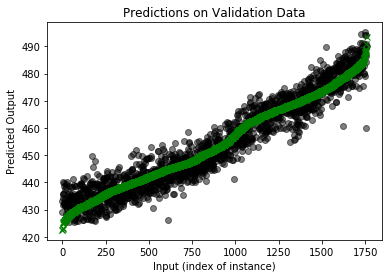

In [50]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# MODEL SELECTION 

**TO DO**: Based on the results of the estimated models (full model and reduced model) **on the validation data** which one would you choose? Explain the choice. Is this choice supported by the predictions of the estimated models **on the test data**? Explain your reasoning.

**ANSWER**
I would choose the full model because RSS on validation is smaller (Loss on validation is smaller). I would choose the full model because RSS on test is smaller (Loss on test is smaller). 

**TO DO**: Based on the results of the estimated models (full model and reduced model) **on the validation data** which one would you choose? Explain the choice.

**ANSWER**


## Confidence intervals for output predictions

Having estimated the coefficients $\hat w$, and given a new location $x_0$, the output prediction  has the form
$$
\hat y_0 : = x_0 ^\top \hat w
$$
and postulating that 
$$
y_0 = x_0^\top w + \epsilon_0 \quad \epsilon_0 \sim {\cal N}(0,\sigma^2)
$$

we would like to compute a confidence interval on the output prediction or equivalently for the estimation error
$$
\tilde y_0:=\hat y_0 - y_0$$
Using the equations above we have that 
$$
\tilde y_0 =x_0^\top (\hat w - w) -  \epsilon_0
$$
where $\epsilon_0$ and $\hat w$ are uncorrelated. It thus follows that 
$$
\tilde y_0 \sim {\cal N}(0, x_0^\top {Var}\{\hat w\}x_0  + \sigma^2)
$$
where
$$
x_0^\top {Var}\{\hat w\}x_0 = \sigma^2 x_0^\top \left(X X^\top\right)^{-1}x_0 \quad \quad
X:=[x_1,..,x_m]
$$
using the results we have seen in class (extended to the case of unknown variance) we have that the interval 
$$
[ - \Delta_0, + \Delta_0] \quad \quad \Delta_0 : = \hat\sigma \, t_{1-\frac{\alpha}{2}}(m_{t}-d-1) \sqrt{x_0^\top (X^\top X)^{-1}x_0 + 1} 
$$
where 
$$
\hat\sigma^2:= \frac{1}{m_t-d-1}\sum_{i\in S_t} (y_i - \hat w^\top x_i)^2
$$
satisfies the condition
$$
\mathbb{P}[\tilde y_0 \in [ - \Delta_0, + \Delta_0]] =\mathbb{P}[\hat  y_0 - y_0 \in [ - \Delta_0, + \Delta_0]]= 1-\alpha
$$
Equivalently we can write
$$
\mathbb{P}[y_0 \in [ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]]  = 1-\alpha
$$
Note that in the latter equation both $y_0$ AND the interval $[ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]$ are random. The probability is to be understood with repect to both the choice of the traning set $(Y,X)$  as well as on the choice of $y_0$. 
With some abuse of terminology we shall say that $[ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]$ is a confidence interval of level $1-\alpha$ for $y_0$.


**TO DO**: compute confidence intervals for output prediction of the FULL model (not the one where some predictors are removed)

In [51]:
# compute predictions on test data

prediction_test=np.zeros(m_test)

for i in range(m_test):
    prediction_test[i] = np.dot(w_np,X_test[i])

print(w_np.shape)
print(X_test[i].shape)

#print the RS on test data
RSS_test=0.

for i in range(m_test):
    RSS_test += (Y_test[i]-prediction_test[i])**2
print("RSS on test set:"+str(RSS_test))
    
#print the Loss on test data
print("Loss from test set:"+str(RSS_test/m_test))

d=X_test.shape[1]-1

sigma2= RSStr_np/(m_training-d-1)
print(sigma2)
t_percentile = t.ppf(1-alpha/2, m_training - d - 1 , loc=0, scale=1)
print(t_percentile)
Z=np.linalg.inv(np.dot(np.transpose(X_training),X_training))

sqrt=(X_test.dot(Z).dot(np.transpose(X_test))+1)**(1/2)
print(sqrt)
Delta_0 = (sigma2**(1/2))*t_percentile*np.diag(sqrt)
print(Delta_0)
A=np.transpose([-Delta_0, Delta_0])
print(A)
CI_0=np.transpose(np.vstack((Y_test,Y_test)))+A
print(CI_0.shape)

(5,)
(5,)
RSS on test set:35692.69617863733
Loss from test set:20.268424860100698
[21.36402679]
1.961316622900012
[[1.00132562 1.00094035 1.00009998 ... 0.99983132 0.99982041 1.00036598]
 [1.00094035 1.0008437  1.00013543 ... 1.00013153 1.00001828 1.00024671]
 [1.00009998 1.00013543 1.00140478 ... 1.00073376 1.00010836 1.00136443]
 ...
 [0.99983132 1.00013153 1.00073376 ... 1.00109485 1.0002634  1.00084257]
 [0.99982041 1.00001828 1.00010836 ... 1.0002634  1.00062087 0.9998588 ]
 [1.00036598 1.00024671 1.00136443 ... 1.00084257 0.9998588  1.00163574]]
[9.07746525 9.07309638 9.07818287 ... 9.07537322 9.07107634 9.08027665]
[[-9.07746525  9.07746525]
 [-9.07309638  9.07309638]
 [-9.07818287  9.07818287]
 ...
 [-9.07537322  9.07537322]
 [-9.07107634  9.07107634]
 [-9.08027665  9.08027665]]
(1761, 2)


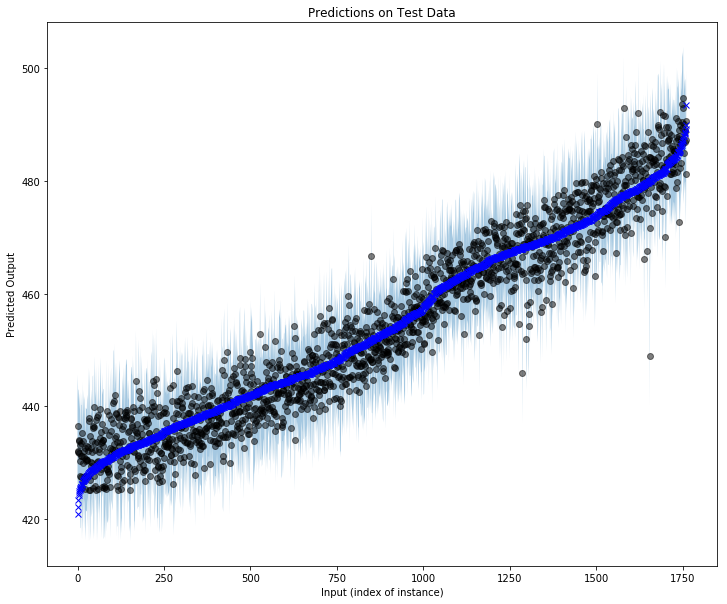

In [52]:
fig=plt.figure(figsize = (12,10))
axx =fig.add_subplot(111)
#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_test[0:m_test])), key=lambda k: prediction_test[0:m_test][k])
axx.plot(Y_test[sorting_permutation], 'ko', alpha=0.5)
axx.plot(prediction_test[sorting_permutation], 'bx')
axx.fill_between(range(m_test), CI_0[sorting_permutation,0],CI_0[sorting_permutation,1], alpha=0.4)

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Test Data')
plt.show()

## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [53]:
# Remove the ``ones'' column in the features matrix (sklearn inserts it automatically)
X_training = X_training[:,1:]
X_test = X_test[:,1:]


In [54]:
from sklearn import linear_model
LinReg = linear_model.LinearRegression()  # build the object LinearRegression
LinReg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)
prediction_training = LinReg.predict(X_training)  # predict output values on training set
prediction_test = LinReg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))


Intercept: 454.08701704545456
Least-Squares Coefficients: [-15.26888273  -2.85893486   0.19942984  -2.4019271 ]
Measure on training data: 0.07084582864869937
